In [89]:
%run resources/library.py

In [90]:
style_notebook()

# Notebook 6: Counting Soho District Building Footprints in Voronoi Cells

In [91]:
import osmnx as ox

ox.__version__

'0.10'

## Using OSMNx footprints feature

Let's assume that most buildings in 1854 Soho district are still intact and have footprints accessible through OSMNx. Let's use the SOHO_COORDINATES from the Cholera Basic Notebooks as a starting point for retrieving building footprints (polygons) using OSMNx `footprints` feature.

In [92]:
SOHO_COORDINATES = (51.513578, -0.136722)

In [93]:
# radius of 700m
distance = 700
footprints_gdf = \
    ox.footprints.footprints_from_point(SOHO_COORDINATES, distance, \
                footprint_type='building', retain_invalid=False)

Let's look at the `geometry` column - these are the building footprint polygons.

In [200]:
footprints_gdf = footprints_gdf[footprints_gdf['geometry'].notnull()]

footprints_gdf

,FIXME,access,addr:city,addr:country,addr:housename,addr:housename:source,addr:housenumber,addr:housenumber:source,addr:postcode,addr:street,...,website,website2,wheelchair,wheelchair:description,wheelchair:description:en,wifi,wikidata,wikimedia_commons,wikipedia,wikipedia_1
4372002,NaN,NaN,London,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.nationalgallery.org.uk/,NaN,yes,NaN,NaN,NaN,Q180788,NaN,en:National Gallery,NaN
10811256,NaN,NaN,London,GB,Broadcasting House,NaN,NaN,NaN,W1A 1AA,Portland Place,...,http://www.bbc.co.uk/broadcastinghouse/visitor...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:Broadcasting House,NaN
26706806,NaN,NaN,London,NaN,NaN,NaN,150,NaN,W1J 9BR,Piccadilly,...,NaN,NaN,limited,NaN,NaN,NaN,Q1481002,NaN,en:Ritz Hotel,NaN
27922125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Q4729656,NaN,NaN,NaN
28416536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,https://www.radissonblu-edwardian.com/london-h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28416571,NaN,NaN,London,NaN,NaN,NaN,9,NaN,WC1B 3QD,Bloomsbury Street,...,https://www.radissonblu-edwardian.com/london-h...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30734422,NaN,NaN,London,NaN,NaN,NaN,NaN,NaN,WC2N 4JH,Trafalgar Square,...,https://www.stmartin-in-the-fields.org/,NaN,yes,"There is access to ticket office, crypt and re...",NaN,NaN,Q1335201,Category:St_Martin-in-the-Fields,en:St Martin-in-the-Fields,NaN
30734455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31327771,NaN,NaN,London,NaN,NaN,NaN,11a,NaN,WC2H 0EP,Charing Cross Road,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31467151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,http://www.stmartin-in-the-fields.org/visiting...,NaN,yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
footprints_gdf['geometry'].head()

4372002     POLYGON ((-0.1278493 51.5092508, -0.1284233 51...
10811256    POLYGON ((-0.1440521 51.5186547, -0.1440056 51...
26706806    POLYGON ((-0.1421522 51.5069798, -0.1413182 51...
27922125    POLYGON ((-0.1431039 51.5183198, -0.1430695 51...
28416536    POLYGON ((-0.1282499 51.5177264, -0.1282245 51...
Name: geometry, dtype: object

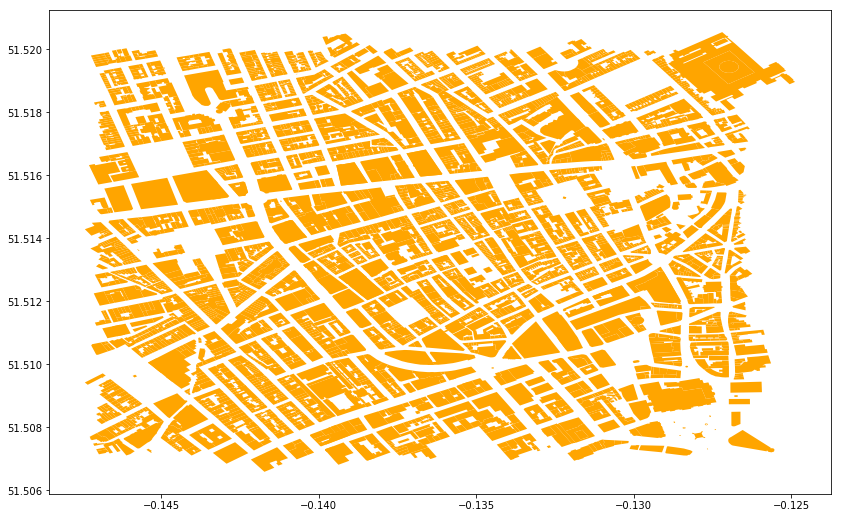

In [146]:
footprints_gdf['geometry'].plot(figsize=(14,12), color='orange')

In [95]:
footprints_gdf['geometry'].centroid

4372002      POINT (-0.1289072363583148 51.50886878638756)
10811256     POINT (-0.1434931157229443 51.51881326478711)
26706806     POINT (-0.1415586528205127 51.50698866859691)
27922125     POINT (-0.1430414183760202 51.51815446703645)
28416536     POINT (-0.1280845786505088 51.51791088165614)
28416571      POINT (-0.127818111335119 51.51750283174328)
30734422     POINT (-0.1266435168407795 51.50882032510657)
30734455      POINT (-0.1267574060639324 51.5082783317942)
31327771     POINT (-0.1283160706146249 51.50993014520074)
31467151     POINT (-0.1267499728296392 51.50899599217346)
31467228     POINT (-0.1264283902644183 51.50927436591335)
32919209     POINT (-0.1263145642079258 51.51046479959339)
32919259       POINT (-0.1301439390095505 51.509089061926)
32919260     POINT (-0.1310949688071529 51.50945926869301)
32919261     POINT (-0.1272900363288314 51.50973930475258)
33632838     POINT (-0.1366511387582964 51.51637140000716)
33719501     POINT (-0.1331361519055229 51.5106757870807

In [147]:
import geopandas as gpd

gpd.__version__

'0.5.1'

## Creating a geodataframe of footprint centroids

The footprint feature of OSMNx allows you to plot polygons of buildings. But to determine if buildings are inside (belongs to) pump voronoi cells, we need to identify buildings by the centroid of its polygon vertices. Fortunately, `geometry` columns in Geopandas are native `shapely` objects. We can get polygon centroids by the attribute `centroid`.

In [201]:
footprints_centroid_gdf = gpd.GeoDataFrame(\
                            geometry=footprints_gdf['geometry'].centroid)\
                            .reset_index()\
                            .rename(columns={'index':'osmid'})

footprints_centroid_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3720 entries, 0 to 3719
Data columns (total 2 columns):
osmid       3720 non-null int64
geometry    3720 non-null object
dtypes: int64(1), object(1)
memory usage: 58.2+ KB


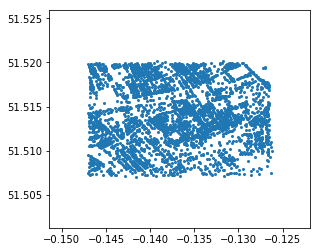

In [223]:
footprints_centroid_gdf.geometry.plot(markersize=4)

## Amplified cognition: Geopandas computational geometry tricks

Let's reload the `clipped_voronoi_gdf` geodataframe.

In [ ]:
clipped_voronoi_gdf = gpd.read_file('outputs/clipped_voronoi.shp')\
    .rename(\
            columns={'vorpoint_l':'vorpoint_lat',\
                     'vorpoint_1':'vorpoint_lon',\
                     'points_in_polygon':'points_in_voronoi'
                    })

In [204]:
clipped_voronoi_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry
0,51.513876,-0.139586,251,Kingly Street,POLYGON ((-0.1410574856914448 51.5114220613506...
1,51.511295,-0.138199,257,Warwick Street,POLYGON ((-0.1367728122831771 51.5087767672292...
2,51.514906,-0.139671,252,Ramillies Place,POLYGON ((-0.1419090932168653 51.5142027957054...
3,51.511542,-0.135919,255,Bridle Lane,POLYGON ((-0.1365516926565943 51.5087101756211...
4,51.513341,-0.136668,250,Broadwick Street,POLYGON ((-0.1363983824619002 51.5175220086050...
5,51.512139,-0.133594,254,Rupert Street,POLYGON ((-0.1332910681829834 51.5174454495886...
6,51.510019,-0.133962,256,Regent Street,POLYGON ((-0.1313808776576417 51.5097731958019...
7,51.512354,-0.131630,253,Dean Street,POLYGON ((-0.1300551818525016 51.5135868616314...


### Intersection

We will use Geopandas' `overlay` function to perform computational geometry tasks. You can go this [link](http://geopandas.org/set_operations.html) to learn more about this. The intersection operation below creates a part of the footprint landscape in the shape of the clipped Voronoi cells.

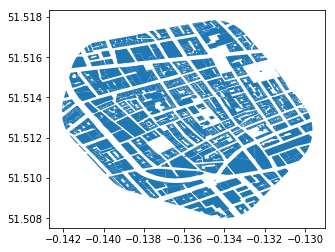

In [193]:
intersection = gpd.overlay(footprints_gdf, clipped_voronoi_gdf, how='intersection')

intersection.plot()

### Difference

The performance of the `difference` function results in a plot of the building footprints minus the area that falls under the clipped Voronoi cells.

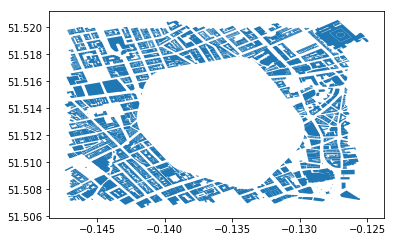

In [205]:
difference1 = gpd.overlay(footprints_gdf, clipped_voronoi_gdf, how='difference')

difference1.plot()

The next difference operation is between geometries for building centroids (`footprints_centroid_gdf`, `shapely` points) and the clipped Voronoi polygons (`clipped_voronoi_gdf`, `shapely` polygons), and is an `sjoin` geopandas operation. The result is a subset of building footprints that lie within the polygons.

In [218]:
difference2 = \
    gpd.sjoin(footprints_centroid_gdf, clipped_voronoi_gdf, how="inner", op='intersects')

In [219]:
difference2

,osmid,geometry,index_right,vorpoint_lat,vorpoint_lon,FID,Street
15,33632838,POINT (-0.1366511387582964 51.51637140000716),4,51.513341,-0.136668,250,Broadwick Street
160,40952627,POINT (-0.1348495223873237 51.51573109618482),4,51.513341,-0.136668,250,Broadwick Street
170,44521980,POINT (-0.1358845274881793 51.51679752577166),4,51.513341,-0.136668,250,Broadwick Street
190,54666913,POINT (-0.1369723104627402 51.51364597629075),4,51.513341,-0.136668,250,Broadwick Street
191,54666919,POINT (-0.137547096210257 51.513754388191),4,51.513341,-0.136668,250,Broadwick Street
192,54666922,POINT (-0.1371887321680014 51.51301974042206),4,51.513341,-0.136668,250,Broadwick Street
193,54666927,POINT (-0.1375450192536432 51.51337866150925),4,51.513341,-0.136668,250,Broadwick Street
194,54666929,POINT (-0.1382061298791459 51.51307253584923),4,51.513341,-0.136668,250,Broadwick Street
195,55873933,POINT (-0.1375061411155153 51.5140761375583),4,51.513341,-0.136668,250,Broadwick Street
196,55873934,POINT (-0.1373846368137981 51.5133165760129),4,51.513341,-0.136668,250,Broadwick Street


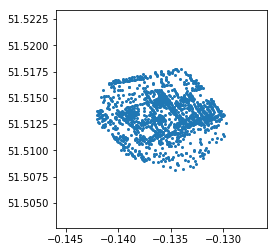

In [221]:
difference2['geometry'].plot(markersize=4)

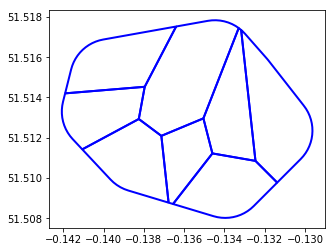

In [225]:
clipped_voronoi_gdf.plot(facecolor="none", edgecolor='blue',linewidth=2)

### Put all the plots together, layer by layer

Let's now add the subplots layer by layer to create a final plot.

Text(0.5, 171.32542827587497, 'Longitude')

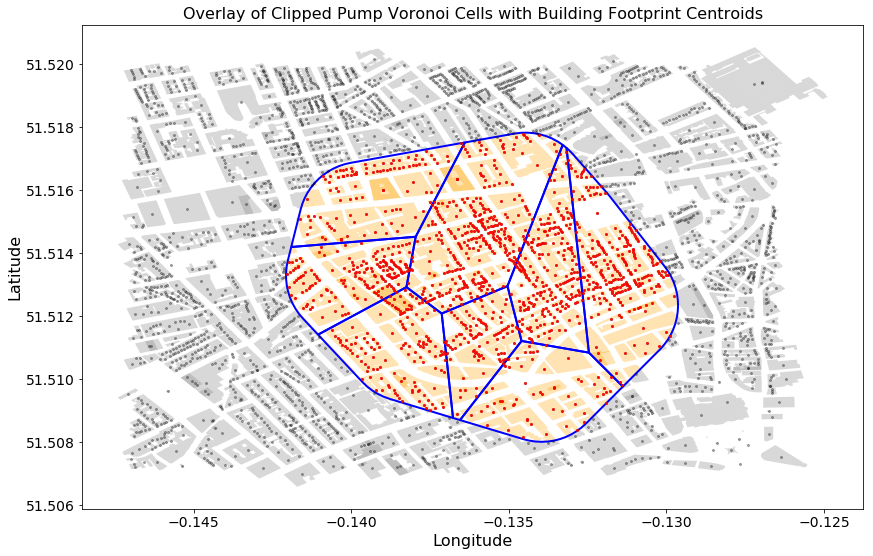

In [222]:
fig, ax = plt.subplots(figsize=(14,12))

# BUILDING FOOTPRINTS POLYGONS LAYER
# layer 1: building footprint polygons minus footprint polygons inside Voronoi cells
difference1['geometry'].plot(color='gray', ax=ax, alpha=0.3)
# layer 2: building footprint polygons that fit within 
intersection.plot(ax=ax, color='orange', linewidth=2, alpha=0.3)

# VORONOI POLYGONS
# layer 3: Voronoi cells from pumps, no fill color
clipped_voronoi_gdf.plot(ax=ax, facecolor="none", edgecolor='blue',linewidth=2)

# BUILDING FOOTPRINTS CENTROID, POINTS LAYER
# layer 4: black points, outside Voronoi cells
footprints_centroid_gdf.geometry.plot(color='black', ax=ax, alpha=0.3, markersize=4)
# layer 5: red points, inside Voronoi cells
difference2['geometry'].plot(color='red', ax=ax, alpha=0.8, markersize=4)

ax.set_title('Overlay of Clipped Pump Voronoi Cells with Building Footprint Centroids', \
             fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)

Orange or gray polygons are the building footprints. Black dots represent the building footprint centroids.

## Reuse the code for identifying death locations within Voronoi cells

In [157]:
%run resources/points_in_polygons.py

In [158]:
# Read the data.
polygons = gpd.GeoDataFrame.from_file('outputs/clipped_voronoi.shp')
points = footprints_centroid_gdf

polygons = points_in_polygons(points, polygons)

polygons

,vorpoint_l,vorpoint_1,FID,Street,geometry,points_in_polygon
0,51.513876,-0.139586,251,Kingly Street,POLYGON ((-0.1410574856914448 51.5114220613506...,177
1,51.511295,-0.138199,257,Warwick Street,POLYGON ((-0.1367728122831771 51.5087767672292...,141
2,51.514906,-0.139671,252,Ramillies Place,POLYGON ((-0.1419090932168653 51.5142027957054...,104
3,51.511542,-0.135919,255,Bridle Lane,POLYGON ((-0.1365516926565943 51.5087101756211...,102
4,51.513341,-0.136668,250,Broadwick Street,POLYGON ((-0.1363983824619002 51.5175220086050...,325
5,51.512139,-0.133594,254,Rupert Street,POLYGON ((-0.1332910681829834 51.5174454495886...,227
6,51.510019,-0.133962,256,Regent Street,POLYGON ((-0.1313808776576417 51.5097731958019...,59
7,51.512354,-0.131630,253,Dean Street,POLYGON ((-0.1300551818525016 51.5135868616314...,252


What we have now is a geodataframe with the number of building centroids found in each Voronoi polygon.

In [159]:
clipped_voronoi_buildings_gdf = \
    polygons.rename(columns={'vorpoint_l':'vorpoint_lat',\
                             'vorpoint_1':'vorpoint_lon',\
                            'points_in_polygon':'buildings_in_voronoi'})

clipped_voronoi_buildings_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry,buildings_in_voronoi
0,51.513876,-0.139586,251,Kingly Street,POLYGON ((-0.1410574856914448 51.5114220613506...,177
1,51.511295,-0.138199,257,Warwick Street,POLYGON ((-0.1367728122831771 51.5087767672292...,141
2,51.514906,-0.139671,252,Ramillies Place,POLYGON ((-0.1419090932168653 51.5142027957054...,104
3,51.511542,-0.135919,255,Bridle Lane,POLYGON ((-0.1365516926565943 51.5087101756211...,102
4,51.513341,-0.136668,250,Broadwick Street,POLYGON ((-0.1363983824619002 51.5175220086050...,325
5,51.512139,-0.133594,254,Rupert Street,POLYGON ((-0.1332910681829834 51.5174454495886...,227
6,51.510019,-0.133962,256,Regent Street,POLYGON ((-0.1313808776576417 51.5097731958019...,59
7,51.512354,-0.131630,253,Dean Street,POLYGON ((-0.1300551818525016 51.5135868616314...,252


Let's save these to files.

In [160]:
clipped_voronoi_buildings_gdf.to_file('outputs/clipped_voronoi_buildings.shp')
clipped_voronoi_buildings_gdf.to_file("outputs/clipped_voronoi_buildings_gdf.json", \
                                      driver="GeoJSON")

## Create the barchart for buildings in Voronoi cells

In [161]:
import pandas as pd

pd.__version__

'0.24.2'

Text(0.5, 0, 'Building Count')

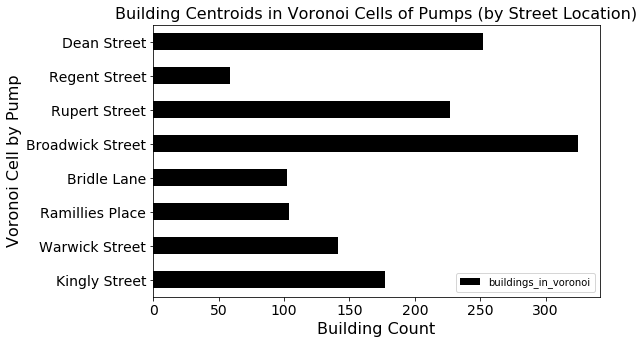

In [162]:
ax = pd.DataFrame(clipped_voronoi_buildings_gdf)\
    .plot.barh(y='buildings_in_voronoi', x='Street', color='k', figsize=(8,5))
ax.set_title('Building Centroids in Voronoi Cells of Pumps (by Street Location)', \
             fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Voronoi Cell by Pump', fontsize=16)
ax.set_xlabel('Building Count', \
              fontsize=16)

## Merge the two geodataframes as Pandas dataframes with essential columns to plot two barcharts

In [163]:
death_locations_df = gpd.read_file('outputs/clipped_voronoi_counts.shp')\
    [['FID','points_in_','Street']].rename(columns={'points_in_':'death_locations'})

death_locations_df

,FID,death_locations,Street
0,251,38,Kingly Street
1,257,12,Warwick Street
2,252,1,Ramillies Place
3,255,21,Bridle Lane
4,250,137,Broadwick Street
5,254,41,Rupert Street
6,256,0,Regent Street
7,253,0,Dean Street


In [164]:
buildings_df = clipped_voronoi_buildings_gdf[['FID','buildings_in_voronoi']]\
        .rename(columns={'buildings_in_voronoi':'buildings'})

buildings_df

,FID,buildings
0,251,177
1,257,141
2,252,104
3,255,102
4,250,325
5,254,227
6,256,59
7,253,252


In [165]:
voronoi_deaths_buildings_df = pd.merge(death_locations_df, buildings_df, \
                                       on='FID', how='inner')

voronoi_deaths_buildings_df

,FID,death_locations,Street,buildings
0,251,38,Kingly Street,177
1,257,12,Warwick Street,141
2,252,1,Ramillies Place,104
3,255,21,Bridle Lane,102
4,250,137,Broadwick Street,325
5,254,41,Rupert Street,227
6,256,0,Regent Street,59
7,253,0,Dean Street,252


## Plotting the two barcharts together...

Text(0.5, 0, 'Point Count')

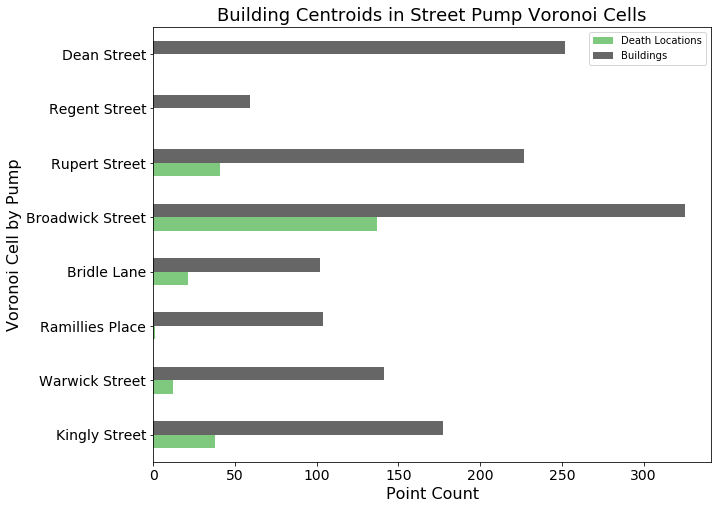

In [226]:
import matplotlib.pyplot as plt

ax = voronoi_deaths_buildings_df[['death_locations','buildings','Street']]\
    .rename(columns={'death_locations':'Death Locations',\
                    'buildings':'Buildings'})\
    .plot.barh(figsize=(10,8), x='Street', colormap='Accent')

ax.set_title('Building Centroids in Street Pump Voronoi Cells', \
             fontsize=18)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Voronoi Cell by Pump', fontsize=16)
ax.set_xlabel('Point Count', \
              fontsize=16)
